In [16]:
import os
import keras
keras.__version__
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

In [17]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [18]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [19]:
keras.backend.tensorflow_backend.set_session(get_session())

# Modelo Pre-Entrenado CNN

In [20]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 120)


# Modelo VGG19

In [22]:
from keras.applications import VGG19

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = VGG19(weights='imagenet',
                          include_top=False,
                          input_shape=(150, 150, 3))

In [23]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [24]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 22,152,632
Trainable params: 22,152,632
Non-trainable params: 0
_________________________________________________________________


In [26]:
conv_base.trainable = False

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 120)               30840     
Total params: 22,152,632
Trainable params: 2,128,248
Non-trainable params: 20,024,384
_________________________________________________________________


In [28]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)

# Optimizador

In [29]:
from keras import optimizers

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.RMSprop(lr=1e-4),
                       metrics=['acc'])

# Entrenamiento

In [30]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=1000,
                                       validation_data=valid_generator,
                                       validation_steps=50)

Epoch 1/1000
100/100 [==============================] - 16s 158ms/step - loss: 4.8638 - acc: 0.0050 - val_loss: 4.7960 - val_acc: 0.0120
Epoch 2/1000
100/100 [==============================] - 14s 141ms/step - loss: 4.7871 - acc: 0.0150 - val_loss: 4.7522 - val_acc: 0.0190
Epoch 3/1000
100/100 [==============================] - 14s 141ms/step - loss: 4.7649 - acc: 0.0115 - val_loss: 4.7057 - val_acc: 0.0340
Epoch 4/1000
100/100 [==============================] - 14s 145ms/step - loss: 4.7335 - acc: 0.0170 - val_loss: 4.7249 - val_acc: 0.0213
Epoch 5/1000
100/100 [==============================] - 14s 144ms/step - loss: 4.7075 - acc: 0.0205 - val_loss: 4.6426 - val_acc: 0.0300
Epoch 6/1000
100/100 [==============================] - 14s 140ms/step - loss: 4.6739 - acc: 0.0280 - val_loss: 4.6026 - val_acc: 0.0350
Epoch 7/1000
100/100 [==============================] - 15s 145ms/step - loss: 4.6575 - acc: 0.0320 - val_loss: 4.5676 - val_acc: 0.0477
Epoch 8/1000
100/100 [===================

100/100 [==============================] - 14s 139ms/step - loss: 3.6531 - acc: 0.1605 - val_loss: 3.6283 - val_acc: 0.1530
Epoch 61/1000
100/100 [==============================] - 14s 142ms/step - loss: 3.5946 - acc: 0.1725 - val_loss: 3.5781 - val_acc: 0.1756
Epoch 62/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.6120 - acc: 0.1775 - val_loss: 3.6363 - val_acc: 0.1470
Epoch 63/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.5907 - acc: 0.1650 - val_loss: 3.5780 - val_acc: 0.1910
Epoch 64/1000
100/100 [==============================] - 14s 140ms/step - loss: 3.6379 - acc: 0.1705 - val_loss: 3.5230 - val_acc: 0.1675
Epoch 65/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.6342 - acc: 0.1790 - val_loss: 3.5914 - val_acc: 0.1580
Epoch 66/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.5448 - acc: 0.1760 - val_loss: 3.5852 - val_acc: 0.1740
Epoch 67/1000
100/100 [=========================

100/100 [==============================] - 14s 143ms/step - loss: 3.3270 - acc: 0.2095 - val_loss: 3.4107 - val_acc: 0.1949
Epoch 120/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.3140 - acc: 0.2250 - val_loss: 3.3054 - val_acc: 0.2240
Epoch 121/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.3735 - acc: 0.2150 - val_loss: 3.3875 - val_acc: 0.2000
Epoch 122/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.3133 - acc: 0.2220 - val_loss: 3.4480 - val_acc: 0.2203
Epoch 123/1000
100/100 [==============================] - 14s 139ms/step - loss: 3.3231 - acc: 0.2215 - val_loss: 3.3385 - val_acc: 0.2180
Epoch 124/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.2928 - acc: 0.2250 - val_loss: 3.3230 - val_acc: 0.2150
Epoch 125/1000
100/100 [==============================] - 14s 142ms/step - loss: 3.2924 - acc: 0.2295 - val_loss: 3.3470 - val_acc: 0.2325
Epoch 126/1000
100/100 [==================

100/100 [==============================] - 14s 141ms/step - loss: 3.1624 - acc: 0.2625 - val_loss: 3.2759 - val_acc: 0.2360
Epoch 179/1000
100/100 [==============================] - 14s 142ms/step - loss: 3.1611 - acc: 0.2560 - val_loss: 3.3089 - val_acc: 0.2240
Epoch 180/1000
100/100 [==============================] - 14s 143ms/step - loss: 3.1017 - acc: 0.2490 - val_loss: 3.3095 - val_acc: 0.2376
Epoch 181/1000
100/100 [==============================] - 14s 140ms/step - loss: 3.1594 - acc: 0.2410 - val_loss: 3.2320 - val_acc: 0.2580
Epoch 182/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.1213 - acc: 0.2550 - val_loss: 3.2904 - val_acc: 0.2360
Epoch 183/1000
100/100 [==============================] - 14s 144ms/step - loss: 3.0624 - acc: 0.2635 - val_loss: 3.2221 - val_acc: 0.2355
Epoch 184/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.1245 - acc: 0.2565 - val_loss: 3.1807 - val_acc: 0.2510
Epoch 185/1000
100/100 [==================

100/100 [==============================] - 14s 140ms/step - loss: 3.0130 - acc: 0.2605 - val_loss: 3.1888 - val_acc: 0.2400
Epoch 238/1000
100/100 [==============================] - 14s 144ms/step - loss: 2.9233 - acc: 0.3050 - val_loss: 3.1304 - val_acc: 0.2447
Epoch 239/1000
100/100 [==============================] - 15s 147ms/step - loss: 3.0223 - acc: 0.2795 - val_loss: 3.2614 - val_acc: 0.2420
Epoch 240/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.0557 - acc: 0.2675 - val_loss: 3.2766 - val_acc: 0.2280
Epoch 241/1000
100/100 [==============================] - 14s 144ms/step - loss: 3.0526 - acc: 0.2765 - val_loss: 3.2624 - val_acc: 0.2406
Epoch 242/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.9880 - acc: 0.2760 - val_loss: 3.1470 - val_acc: 0.2440
Epoch 243/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.9882 - acc: 0.2785 - val_loss: 3.2836 - val_acc: 0.2210
Epoch 244/1000
100/100 [==================

100/100 [==============================] - 14s 140ms/step - loss: 2.8901 - acc: 0.2990 - val_loss: 3.1598 - val_acc: 0.2460
Epoch 297/1000
100/100 [==============================] - 14s 141ms/step - loss: 3.0119 - acc: 0.2760 - val_loss: 3.3064 - val_acc: 0.2520
Epoch 298/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.9709 - acc: 0.2830 - val_loss: 3.2717 - val_acc: 0.2487
Epoch 299/1000
100/100 [==============================] - 15s 147ms/step - loss: 2.8281 - acc: 0.3050 - val_loss: 3.2986 - val_acc: 0.2380
Epoch 300/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.9178 - acc: 0.2945 - val_loss: 3.2600 - val_acc: 0.2480
Epoch 301/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.8943 - acc: 0.2940 - val_loss: 3.1256 - val_acc: 0.2650
Epoch 302/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.9568 - acc: 0.2780 - val_loss: 3.2754 - val_acc: 0.2500
Epoch 303/1000
100/100 [==================

100/100 [==============================] - 14s 141ms/step - loss: 2.8248 - acc: 0.3055 - val_loss: 3.2286 - val_acc: 0.2480
Epoch 356/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.8949 - acc: 0.2860 - val_loss: 3.1924 - val_acc: 0.2650
Epoch 357/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.8132 - acc: 0.3090 - val_loss: 3.3571 - val_acc: 0.2330
Epoch 358/1000
100/100 [==============================] - 14s 138ms/step - loss: 2.8282 - acc: 0.3095 - val_loss: 3.1594 - val_acc: 0.2630
Epoch 359/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.8036 - acc: 0.3165 - val_loss: 3.2058 - val_acc: 0.2660
Epoch 360/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.8446 - acc: 0.3030 - val_loss: 3.2803 - val_acc: 0.2430
Epoch 361/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.8270 - acc: 0.3170 - val_loss: 3.1952 - val_acc: 0.2640
Epoch 362/1000
100/100 [==================

100/100 [==============================] - 14s 143ms/step - loss: 2.8345 - acc: 0.3130 - val_loss: 3.3177 - val_acc: 0.2426
Epoch 415/1000
100/100 [==============================] - 14s 142ms/step - loss: 2.7319 - acc: 0.3335 - val_loss: 3.3018 - val_acc: 0.2560
Epoch 416/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.7995 - acc: 0.3230 - val_loss: 3.1202 - val_acc: 0.2720
Epoch 417/1000
100/100 [==============================] - 14s 142ms/step - loss: 2.7020 - acc: 0.3345 - val_loss: 3.2903 - val_acc: 0.2548
Epoch 418/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.8310 - acc: 0.3115 - val_loss: 3.1998 - val_acc: 0.2730
Epoch 419/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.8531 - acc: 0.3120 - val_loss: 3.2747 - val_acc: 0.2570
Epoch 420/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.7494 - acc: 0.3105 - val_loss: 3.3175 - val_acc: 0.2294
Epoch 421/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.7330 - acc: 0.3345 - val_loss: 3.3248 - val_acc: 0.2480
Epoch 474/1000
100/100 [==============================] - 14s 138ms/step - loss: 2.7079 - acc: 0.3370 - val_loss: 3.3263 - val_acc: 0.2580
Epoch 475/1000
100/100 [==============================] - 14s 144ms/step - loss: 2.7044 - acc: 0.3200 - val_loss: 3.2700 - val_acc: 0.2619
Epoch 476/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.7541 - acc: 0.3250 - val_loss: 3.3808 - val_acc: 0.2320
Epoch 477/1000
100/100 [==============================] - 14s 138ms/step - loss: 2.7226 - acc: 0.3280 - val_loss: 3.1800 - val_acc: 0.2670
Epoch 478/1000
100/100 [==============================] - 14s 142ms/step - loss: 2.7721 - acc: 0.3240 - val_loss: 3.3434 - val_acc: 0.2487
Epoch 479/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.7592 - acc: 0.3215 - val_loss: 3.2323 - val_acc: 0.2670
Epoch 480/1000
100/100 [==================

100/100 [==============================] - 14s 140ms/step - loss: 2.6074 - acc: 0.3615 - val_loss: 3.3488 - val_acc: 0.2660
Epoch 533/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.6323 - acc: 0.3390 - val_loss: 3.3349 - val_acc: 0.2510
Epoch 534/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.7807 - acc: 0.3365 - val_loss: 3.3577 - val_acc: 0.2620
Epoch 535/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6981 - acc: 0.3300 - val_loss: 3.2778 - val_acc: 0.2550
Epoch 536/1000
100/100 [==============================] - 14s 143ms/step - loss: 2.6717 - acc: 0.3450 - val_loss: 3.3017 - val_acc: 0.2599
Epoch 537/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6739 - acc: 0.3440 - val_loss: 3.2851 - val_acc: 0.2690
Epoch 538/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6956 - acc: 0.3330 - val_loss: 3.3185 - val_acc: 0.2590
Epoch 539/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.5983 - acc: 0.3610 - val_loss: 3.2593 - val_acc: 0.2860
Epoch 592/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.6550 - acc: 0.3475 - val_loss: 3.3713 - val_acc: 0.2580
Epoch 593/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6632 - acc: 0.3390 - val_loss: 3.3327 - val_acc: 0.2772
Epoch 594/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6921 - acc: 0.3410 - val_loss: 3.3159 - val_acc: 0.2580
Epoch 595/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.6362 - acc: 0.3450 - val_loss: 3.3859 - val_acc: 0.2470
Epoch 596/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6736 - acc: 0.3460 - val_loss: 3.2920 - val_acc: 0.2660
Epoch 597/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.7064 - acc: 0.3420 - val_loss: 3.3923 - val_acc: 0.2470
Epoch 598/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.6288 - acc: 0.3475 - val_loss: 3.4017 - val_acc: 0.2490
Epoch 651/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.6678 - acc: 0.3290 - val_loss: 3.5204 - val_acc: 0.2589
Epoch 652/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.6318 - acc: 0.3520 - val_loss: 3.2697 - val_acc: 0.2730
Epoch 653/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5844 - acc: 0.3520 - val_loss: 3.4551 - val_acc: 0.2540
Epoch 654/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.6530 - acc: 0.3525 - val_loss: 3.3982 - val_acc: 0.2690
Epoch 655/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5368 - acc: 0.3605 - val_loss: 3.3942 - val_acc: 0.2640
Epoch 656/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.5816 - acc: 0.3645 - val_loss: 3.3386 - val_acc: 0.2500
Epoch 657/1000
100/100 [==================

100/100 [==============================] - 14s 142ms/step - loss: 2.5481 - acc: 0.3690 - val_loss: 3.2804 - val_acc: 0.2954
Epoch 710/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.5967 - acc: 0.3380 - val_loss: 3.2915 - val_acc: 0.2800
Epoch 711/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.5760 - acc: 0.3735 - val_loss: 3.5072 - val_acc: 0.2620
Epoch 712/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.6500 - acc: 0.3470 - val_loss: 3.5881 - val_acc: 0.2284
Epoch 713/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5861 - acc: 0.3620 - val_loss: 3.3787 - val_acc: 0.2570
Epoch 714/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5636 - acc: 0.3645 - val_loss: 3.3683 - val_acc: 0.2560
Epoch 715/1000
100/100 [==============================] - 14s 143ms/step - loss: 2.5112 - acc: 0.3600 - val_loss: 3.5725 - val_acc: 0.2335
Epoch 716/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.5404 - acc: 0.3645 - val_loss: 3.4746 - val_acc: 0.2520
Epoch 769/1000
100/100 [==============================] - 14s 143ms/step - loss: 2.5577 - acc: 0.3580 - val_loss: 3.3152 - val_acc: 0.2720
Epoch 770/1000
100/100 [==============================] - 14s 144ms/step - loss: 2.5820 - acc: 0.3640 - val_loss: 3.4425 - val_acc: 0.2538
Epoch 771/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.4785 - acc: 0.3975 - val_loss: 3.4589 - val_acc: 0.2760
Epoch 772/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5223 - acc: 0.3630 - val_loss: 3.4178 - val_acc: 0.2430
Epoch 773/1000
100/100 [==============================] - 14s 144ms/step - loss: 2.5264 - acc: 0.3665 - val_loss: 3.6032 - val_acc: 0.2416
Epoch 774/1000
100/100 [==============================] - 14s 142ms/step - loss: 2.5700 - acc: 0.3700 - val_loss: 3.4342 - val_acc: 0.2570
Epoch 775/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.5332 - acc: 0.3695 - val_loss: 3.4018 - val_acc: 0.2335
Epoch 828/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5975 - acc: 0.3480 - val_loss: 3.3745 - val_acc: 0.2540
Epoch 829/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5567 - acc: 0.3775 - val_loss: 3.4806 - val_acc: 0.2480
Epoch 830/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.4694 - acc: 0.3885 - val_loss: 3.6271 - val_acc: 0.2518
Epoch 831/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.4753 - acc: 0.3750 - val_loss: 3.5691 - val_acc: 0.2440
Epoch 832/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5428 - acc: 0.3615 - val_loss: 3.5445 - val_acc: 0.2490
Epoch 833/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.5187 - acc: 0.3810 - val_loss: 3.2885 - val_acc: 0.2802
Epoch 834/1000
100/100 [==================

100/100 [==============================] - 14s 139ms/step - loss: 2.4775 - acc: 0.3645 - val_loss: 3.4079 - val_acc: 0.2740
Epoch 887/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5395 - acc: 0.3695 - val_loss: 3.4704 - val_acc: 0.2590
Epoch 888/1000
100/100 [==============================] - 14s 141ms/step - loss: 2.4273 - acc: 0.3860 - val_loss: 3.5629 - val_acc: 0.2457
Epoch 889/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.5596 - acc: 0.3645 - val_loss: 3.4819 - val_acc: 0.2630
Epoch 890/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.4443 - acc: 0.3825 - val_loss: 3.4605 - val_acc: 0.2720
Epoch 891/1000
100/100 [==============================] - 14s 142ms/step - loss: 2.4721 - acc: 0.3865 - val_loss: 3.5216 - val_acc: 0.2629
Epoch 892/1000
100/100 [==============================] - 14s 138ms/step - loss: 2.4907 - acc: 0.3755 - val_loss: 3.4918 - val_acc: 0.2580
Epoch 893/1000
100/100 [==================

100/100 [==============================] - 14s 140ms/step - loss: 2.5469 - acc: 0.3785 - val_loss: 3.6106 - val_acc: 0.2340
Epoch 946/1000
100/100 [==============================] - 15s 148ms/step - loss: 2.4322 - acc: 0.3910 - val_loss: 3.6547 - val_acc: 0.2416
Epoch 947/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.4126 - acc: 0.3915 - val_loss: 3.5422 - val_acc: 0.2580
Epoch 948/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.5360 - acc: 0.3675 - val_loss: 3.4945 - val_acc: 0.2560
Epoch 949/1000
100/100 [==============================] - 14s 143ms/step - loss: 2.4164 - acc: 0.3760 - val_loss: 3.4661 - val_acc: 0.2650
Epoch 950/1000
100/100 [==============================] - 14s 140ms/step - loss: 2.4255 - acc: 0.3880 - val_loss: 3.6927 - val_acc: 0.2510
Epoch 951/1000
100/100 [==============================] - 14s 139ms/step - loss: 2.6161 - acc: 0.3640 - val_loss: 3.4414 - val_acc: 0.2730
Epoch 952/1000
100/100 [==================

# Graficos

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

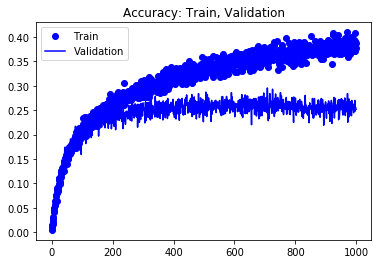

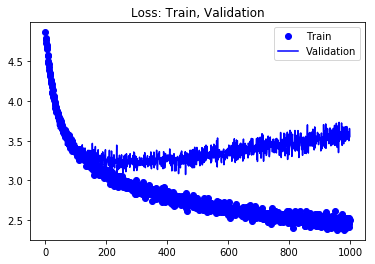

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [33]:
model.save('vgg19_model.h5')